In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

#Определяем отсутствующие значения. 
#Преобразуем "?" в NaN и переименуем столбец для большего удобства.

raw_data = pd.read_csv('dataset/VehicleDataset.csv')
raw_data.columns = [column.lower().replace("-", "_").replace(" ", "_") for column in raw_data.columns]

df=raw_data.copy() 
df.replace('?', np.nan, inplace = True) 

In [2]:
#Проверим количество беспорядочных значений в каждом столбце.
#Каждый столбец имеет 205 строк данных и 7 столбцов, содержащих отсутствующие данные:
#нормализованные потери: 41 отсутствующие данные
#количество дверей: 2 отсутствующие данные
#bore: 4 отсутствующих данных
#stroke: 4 отсутствующих данных
#horsepower:  2 отсутствующих данных
#пиковые обороты в минуту: 2 отсутствующих данных
#цена: 4 отсутствующих данных
missing_data = df.isnull() 
display(df.isnull())

for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
201,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
202,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
203,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


symboling
False    205
Name: symboling, dtype: int64

normalized_losses
False    164
True      41
Name: normalized_losses, dtype: int64

make
False    205
Name: make, dtype: int64

fuel_type
False    205
Name: fuel_type, dtype: int64

aspiration
False    205
Name: aspiration, dtype: int64

num_of_doors
False    203
True       2
Name: num_of_doors, dtype: int64

body_style
False    205
Name: body_style, dtype: int64

drive_wheels
False    205
Name: drive_wheels, dtype: int64

engine_location
False    205
Name: engine_location, dtype: int64

wheel_base
False    205
Name: wheel_base, dtype: int64

length
False    205
Name: length, dtype: int64

width
False    205
Name: width, dtype: int64

height
False    205
Name: height, dtype: int64

curb_weight
False    205
Name: curb_weight, dtype: int64

engine_type
False    205
Name: engine_type, dtype: int64

num_of_cylinders
False    205
Name: num_of_cylinders, dtype: int64

engine_size
False    205
Name: engine_size, dtype: int64

fuel_system
Fa

In [3]:
#Анализ данных
#84.04% Седан - четырехдверный.
#Было бы разумно, если бы пропущенные данные по количеству дверей были заменены на четыре.
#Пропущенные данные с натуральными числами можно заменить средним значением по всему столбцу.
#Пропущенные данные о цене будут удалены, потому что цена - это то, что мы хотим предсказать.
#Любые данные без данных о цене не могут быть использованы для прогнозирования.
print(raw_data[["num_of_doors", "body_style"]].groupby("body_style").value_counts(), 
      "\n{}% sedan is four doors.".format(round(79/(79+15)*100,2)))

body_style   num_of_doors
convertible  two              6
hardtop      two              8
hatchback    two             60
             four            10
sedan        four            79
             two             15
             ?                2
wagon        four            25
dtype: int64 
84.04% sedan is four doors.


In [4]:
#Восстановим отсутствующие значения или выпадающие значения
#Заменим на среднее значение:

#нормализованные потери : 41 отсутствующих данных, заменим их средним значением
#stroke : 4 отсутствующих данных, заменим их средним значением
#bore : 4 отсутствующих данных, заменим их средним значением
#лошадиная сила : 2 отсутствующих данных, заменим их средним значением
#пик-об/мин : 2 отсутствующих данных, заменим их средним значением
#Замена по частоте:

#количество дверей : 2 пропущенных данных, заменим их на "четыре".
#Отбросьте все 4 строки:

#цена: 4 отсутствующих данных, просто удаляем всю строку


df.dropna(subset=["price"],axis=0,inplace=True) 
df.reset_index(drop=True,inplace=True) 

In [5]:
#Replace and Convert
#Замена среднего значения 
for index, column in enumerate(["normalized_losses", "bore", "stroke", "horsepower", "peak_rpm"]):
        avg_value = df[column].astype("float").mean(axis=0)
        print("Average of {} : {}".format(column.replace("_", " "), round(avg_value,2)))
        df[column].replace(np.nan, avg_value, inplace=True)
        
#Конвентирование данных
type_ = [int, float, float, int, int, float]       
for index, column in enumerate(["normalized_losses", "bore", "stroke", "horsepower", "peak_rpm", "price"]):
        df[column] = df[column].astype(type_[index])
        

#Декодирование данных
df_tr = df.copy()        
for title in df_tr.select_dtypes(include='object').columns:
        df_tr[title] = LabelEncoder().fit_transform(df_tr[title].values)

Average of normalized losses : 122.0
Average of bore : 3.33
Average of stroke : 3.26
Average of horsepower : 103.4
Average of peak rpm : 5117.59


In [6]:
#Квантиль
df_tr = df_tr[df_tr.price < df_tr.price.quantile(0.9)]
df_tr

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,122,0,1,0,1,0,2,0,88.6,...,130,5,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,122,0,1,0,1,0,2,0,88.6,...,130,5,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,122,0,1,0,1,2,2,0,94.5,...,152,5,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,164,1,1,0,0,3,1,0,99.8,...,109,5,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,164,1,1,0,0,3,0,0,99.4,...,136,5,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,-2,103,21,1,1,0,3,2,0,104.3,...,130,5,3.62,3.15,7.5,162,5100,17,22,18420.0
195,-1,74,21,1,1,0,4,2,0,104.3,...,130,5,3.62,3.15,7.5,162,5100,17,22,18950.0
196,-1,95,21,1,0,0,3,2,0,109.1,...,141,5,3.78,3.15,9.5,114,5400,23,28,16845.0
197,-1,95,21,1,1,0,3,2,0,109.1,...,141,5,3.78,3.15,8.7,160,5300,19,25,19045.0


In [7]:
#Описание статистического анализ
from scipy.stats import pearsonr, f_oneway
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold

#Корреляция пирсона
def udf_pearsonr(X, y): 
    result = np.array([pearsonr(x, y) for x in X.T])
    return np.absolute(result[:,0]), result[:,1] 


def organize(data, titles:[], target='price'):
    set_x = data.loc[:,titles]
    y = set_x[target]
    set_x = set_x.drop(target, axis=1)
    return np.array(set_x.values.tolist()),y.values.tolist()


selector_varianceThreshold = VarianceThreshold(0.2)

selected_data = selector_varianceThreshold.fit_transform(df_tr)

title_features = selector_varianceThreshold.get_feature_names_out(df_tr.columns)
display(title_features)

X, y = organize(df_tr, title_features)

train_set = X
train_y = y
display(len(title_features))

array(['symboling', 'normalized_losses', 'make', 'num_of_doors',
       'body_style', 'drive_wheels', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'engine_type', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'compression_ratio', 'horsepower',
       'peak_rpm', 'city_mpg', 'highway_mpg', 'price'], dtype=object)

21

In [8]:
for idx in range(train_set.shape[1]):
    title = title_features[idx].replace("_", " ").capitalize()
    pea_score, p_value = pearsonr(train_set[:,idx], train_y)
    print(f"{title} has correlation {round(np.abs(pea_score),3)}, p-value is {p_value}".format())

Symboling has correlation 0.036, p-value is 0.6331842154850545
Normalized losses has correlation 0.317, p-value is 1.4352759788069227e-05
Make has correlation 0.005, p-value is 0.9465789197062073
Num of doors has correlation 0.122, p-value is 0.10254970734462912
Body style has correlation 0.085, p-value is 0.25421650817357294
Drive wheels has correlation 0.565, p-value is 1.5008084787375338e-16
Wheel base has correlation 0.612, p-value is 7.210669291835463e-20
Length has correlation 0.716, p-value is 1.3237649365440924e-29
Width has correlation 0.745, p-value is 4.483940735629761e-33
Height has correlation 0.187, p-value is 0.012055937204577285
Curb weight has correlation 0.838, p-value is 1.3532161301065677e-48
Engine type has correlation 0.053, p-value is 0.4819564774757745
Num of cylinders has correlation 0.155, p-value is 0.03756021162069747
Engine size has correlation 0.725, p-value is 1.1540207363299491e-30
Fuel system has correlation 0.671, p-value is 7.219421668533878e-25
Compr

In [9]:
x_set = X
y = y
clf = RandomForestRegressor(n_estimators = 50, random_state = 123)
clf.fit(x_set, y)

sorted(np.round(clf.feature_importances_, 4), reverse=True)

[0.5894,
 0.1578,
 0.0642,
 0.0332,
 0.028,
 0.0177,
 0.0177,
 0.017,
 0.0135,
 0.0108,
 0.0101,
 0.0087,
 0.0081,
 0.0062,
 0.0059,
 0.0052,
 0.0028,
 0.0021,
 0.0011,
 0.0006]

<BarContainer object of 20 artists>

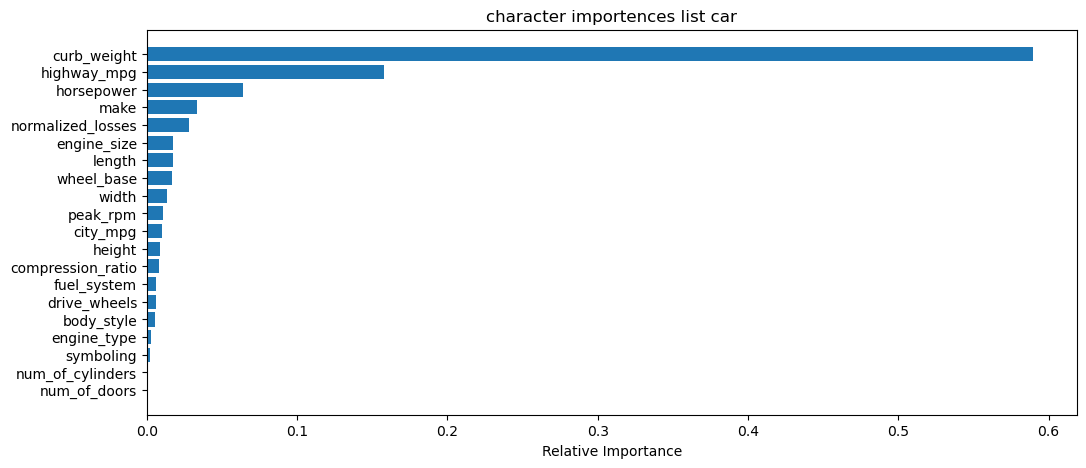

In [10]:
fig, ax=plt.subplots(figsize=(12,5))
importances = clf.feature_importances_
indices =np.argsort(importances)
ax.set(title="character importences list car", xlabel="Relative Importance", ylabel=None)
plt.yticks(range(len(indices)),np.array(title_features)[indices])
ax.barh(range(len(indices)), importances[indices])

<AxesSubplot:xlabel='body_style', ylabel='price'>

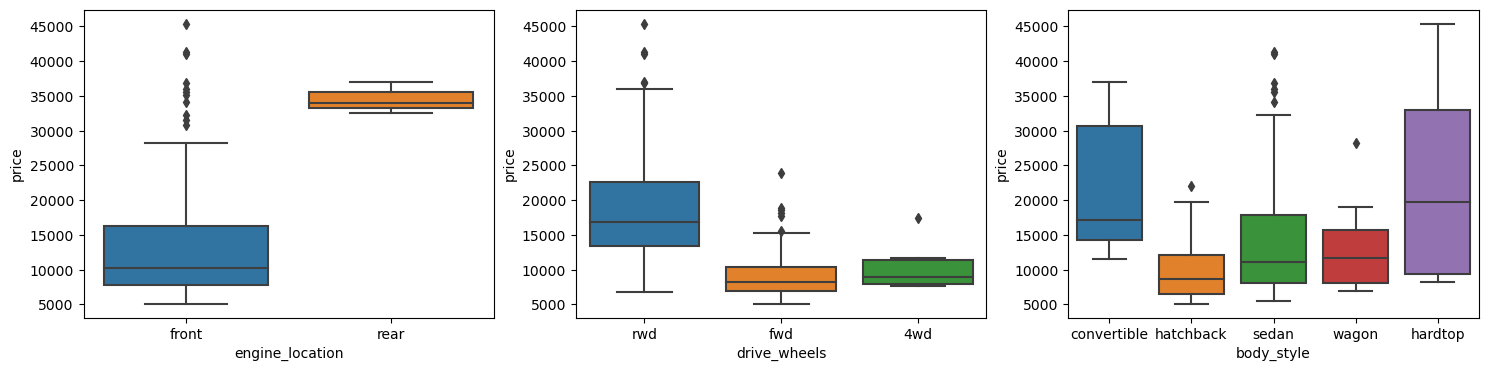

In [11]:
fig, axes = plt.subplots(1,3, figsize=(18,4))
sns.boxplot(x="engine_location", y="price", data=df, ax=axes[0])
sns.boxplot(x="drive_wheels", y="price", data=df, ax=axes[1])
sns.boxplot(x="body_style", y="price", data=df, ax=axes[2])

In [12]:
#Подготовка данных для гафика
grouped_df = df[["price","engine_type","body_style"]].groupby(["engine_type","body_style"],as_index=False).mean().sort_values(["price"])
grouped_pivot = grouped_df.pivot(index='engine_type',columns='body_style')
grouped_pivot

price                                                   
body_style  convertible  hardtop     hatchback         sedan         wagon
engine_type                                                               
dohc            14997.5      NaN  15061.000000  22281.600000  15750.000000
l                   NaN      NaN   5151.000000  15758.571429  15017.500000
ohc             14632.0  13142.4   9001.153846  13134.070423  12114.133333
ohcf            37028.0  33278.0   6591.333333   9070.600000   9342.000000
ohcv            35056.0  45400.0  17949.250000  26604.500000  14399.000000
rotor               NaN      NaN  13020.000000           NaN           NaN

In [13]:
grouped_pivot = grouped_pivot.fillna(0) 
grouped_pivot

price                                                   
body_style  convertible  hardtop     hatchback         sedan         wagon
engine_type                                                               
dohc            14997.5      0.0  15061.000000  22281.600000  15750.000000
l                   0.0      0.0   5151.000000  15758.571429  15017.500000
ohc             14632.0  13142.4   9001.153846  13134.070423  12114.133333
ohcf            37028.0  33278.0   6591.333333   9070.600000   9342.000000
ohcv            35056.0  45400.0  17949.250000  26604.500000  14399.000000
rotor               0.0      0.0  13020.000000      0.000000      0.000000

[Text(0.5, 0, 'convertible'),
 Text(1.5, 0, 'hatchback'),
 Text(2.5, 0, 'sedan'),
 Text(3.5, 0, 'wagon'),
 Text(4.5, 0, 'hardtop')]

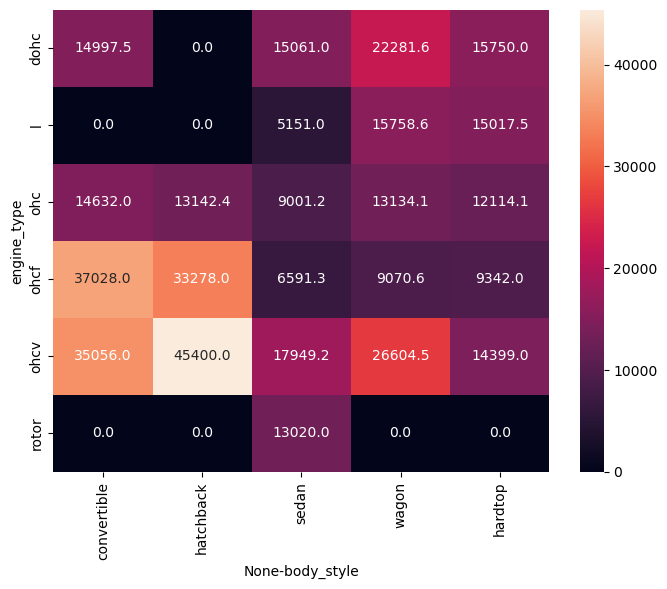

In [14]:
fig, axes = plt.subplots(figsize=(8,6))
sns.heatmap(grouped_pivot, annot=True, fmt=".1f")
axes.set_xticklabels(labels=df.body_style.unique(), rotation=90)

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
symboling,1.000000,0.469181,-0.183522,0.120406,0.039774,0.629481,-0.581185,-0.006649,-0.484714,-0.303979,...,-0.072116,0.102230,-0.144327,0.086538,-0.111119,0.110728,0.226272,-0.071358,-0.015546,-0.035810
normalized_losses,0.469181,1.000000,-0.258143,0.036142,0.046669,0.376207,-0.271610,0.385673,-0.024462,0.050270,...,0.214904,0.233107,-0.011883,0.073881,-0.050942,0.285868,0.232208,-0.251010,-0.212883,0.317185
make,-0.183522,-0.258143,1.000000,-0.129079,0.073686,-0.224496,0.133122,0.026853,0.239625,0.284833,...,0.122425,0.212733,0.327105,-0.176973,0.141635,0.067935,-0.293087,-0.030589,-0.051106,0.005029
fuel_type,0.120406,0.036142,-0.129079,1.000000,-0.305275,0.109554,-0.155114,-0.078883,-0.268661,-0.173383,...,-0.064454,0.016328,-0.047616,-0.201953,-0.984210,0.237499,0.455792,-0.333473,-0.293179,-0.076228
aspiration,0.039774,0.046669,0.073686,-0.305275,1.000000,0.022932,0.042554,0.069109,0.209767,0.206161,...,0.222519,0.337157,0.265724,0.194377,0.182160,0.400908,-0.155471,-0.229502,-0.271860,0.300482
num_of_doors,0.629481,0.376207,-0.224496,0.109554,0.022932,1.000000,-0.636015,0.112509,-0.439774,-0.408137,...,-0.074689,0.015047,-0.162027,0.100556,-0.102996,0.061958,0.198075,0.060364,0.067981,-0.122083
body_style,-0.581185,-0.271610,0.133122,-0.155114,0.042554,-0.636015,1.000000,-0.143945,0.446349,0.406565,...,0.029399,-0.026026,0.094766,-0.086382,0.141467,-0.060884,-0.076223,-0.042675,-0.077201,0.085423
drive_wheels,-0.006649,0.385673,0.026853,-0.078883,0.069109,0.112509,-0.143945,1.000000,0.428382,0.417703,...,0.447817,0.401800,0.403618,0.043765,0.070997,0.471384,0.019897,-0.383748,-0.378381,0.564693
wheel_base,-0.484714,-0.024462,0.239625,-0.268661,0.209767,-0.439774,0.446349,0.428382,1.000000,0.849718,...,0.519054,0.406742,0.519342,0.005650,0.217204,0.347697,-0.271700,-0.437645,-0.479311,0.611855
length,-0.303979,0.050270,0.284833,-0.173383,0.206161,-0.408137,0.406565,0.417703,0.849718,1.000000,...,0.658849,0.558933,0.611936,0.017143,0.125231,0.547532,-0.218542,-0.626512,-0.634233,0.716127


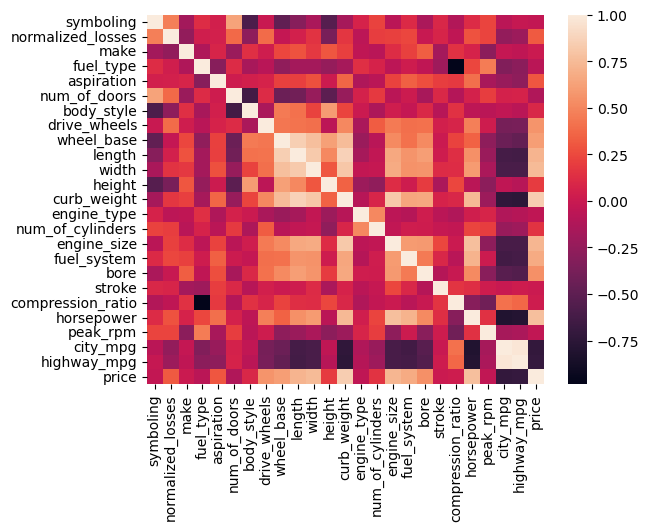

In [15]:
correlation = df_tr.drop(["engine_location"], axis=1).corr(min_periods=3)
sns.heatmap(correlation)
display(correlation)